# 0 Utils

In [1]:
import os
import numpy as np
import seaborn as sb
%matplotlib inline
sb.set()
import matplotlib.pyplot as plt
import pandas as pd

N_JOBS = 6
RANDOM_STATE = 42

## Experiment Setting 

In [2]:
import time
start_time = time.time()


In [3]:
# dataset, base nro 2
dataset_nro = 6
# nombre experimento
exp_name = "Experimento 28"

# 1 Load Dataset

In [4]:
dataset = 'personas_cotizacion{}.csv'.format(dataset_nro)

# DS_NAME = dataset.split('.')[0]
DS_NAME = exp_name

folder = '..\\results\\model_results\\{}'.format(DS_NAME)

if not os.path.exists(folder):
    os.mkdir(folder)


personas = pd.read_csv('..\\..\\Datos\\experiments\\{}'.format(dataset), encoding = "ISO-8859-1")

readme = dict()
readme['experiment_name'] = DS_NAME
readme['experiment_dataset'] = dataset

print(personas.shape)
readme['personas_shape'] = personas.shape
# personas.head(2)

print(personas.columns)
readme['personas_columns'] = personas.columns.tolist()

(6184, 36)
Index(['Unnamed: 0', 'is_apellido1', 'is_appelido2', 'is_celular',
       'is_direccion', 'is_fnac', 'is_nombre', 'is_nombrecompleto',
       'is_nrofam', 'is_profesion', 'is_recontacto', 'is_telefono',
       'loc_comuna', 'loc_provincia', 'loc_region', 'max_rango_edad',
       'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
       'medio_inicial', 'negocio', 'nro_cot_bod', 'nro_cot_depto',
       'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos', 'profesion', 'rut',
       'sexo', 'tipo_cliente', 'Altos del Valle', 'Edificio Urban 1470',
       'San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'],
      dtype='object')


In [5]:
tab_info=pd.DataFrame(personas.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(personas.isnull().sum()/personas.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

,Unnamed: 0,is_apellido1,is_appelido2,is_celular,is_direccion,is_fnac,is_nombre,is_nombrecompleto,is_nrofam,is_profesion,...,nro_proyectos,profesion,rut,sexo,tipo_cliente,Altos del Valle,Edificio Urban 1470,San Andres Del Valle,Edificio Mil610,Edificio Junge
column type,int64,bool,bool,bool,bool,bool,bool,bool,bool,bool,...,float64,object,object,object,object,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001994E5F9A58>,
      dtype=object)

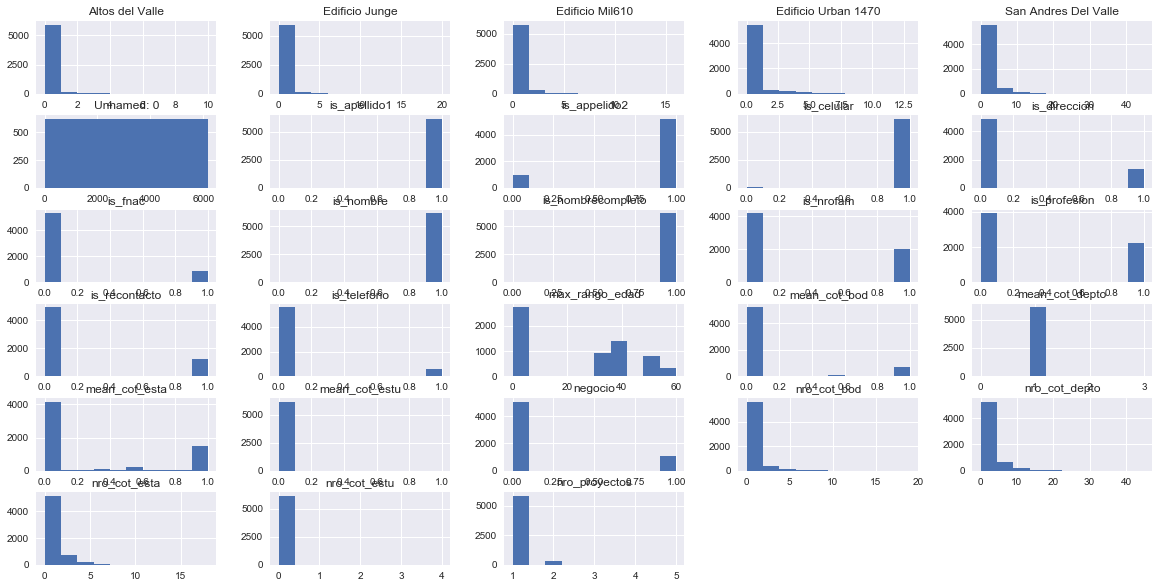

In [6]:
personas.hist(figsize=(20,10))

In [7]:
# Ajustes especificos experimento
# Para E5D5, E6D5 #########################################
# mask = (personas['San Andres Del Valle'] > 0)
# personas = personas[mask]
# print(personas[mask].shape)
# personas[mask]
###########################################################

predictors = ['is_apellido1', 'is_appelido2', 'is_celular', 'is_direccion', 'is_fnac',
       'is_nombre', 'is_nombrecompleto', 'is_nrofam', 'is_telefono','is_profesion',
       'loc_comuna', 'loc_provincia', 'loc_region', 'mean_cot_bod',
       'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu', 'nro_cot_bod',
       'nro_cot_depto', 'nro_cot_esta', 'nro_cot_estu', 'nro_proyectos',
       'profesion', 'sexo', 'tipo_cliente', 'Altos del Valle',
       'Edificio Urban 1470', 'San Andres Del Valle', 'Edificio Mil610',
       'Edificio Junge']

# print(personas[personas['profesion']=='sin informacion'].shape)
# print(personas.profesion.nunique())
# print(personas.is_profesion.unique())

# En que experimento use esto? E8D6 y E28D6
# Se usa en los experimentos de data set limpio para evaluar con las personas que si entregaron la profesion
personas.replace(['sin informacion'], np.nan, inplace=True)
personas.dropna(inplace=True)

In [8]:
# Ready Data Set

drop_columns = [
    personas.columns[0], 'rut', 'negocio', 'max_rango_edad', 
    'is_profesion',
#     'mean_cot_bod', 'mean_cot_depto', 'mean_cot_esta', 'mean_cot_estu',
#     'nro_cot_bod', 'nro_cot_depto', 'nro_cot_esta', 'nro_cot_estu',
#     'Altos del Valle', 'Edificio Urban 1470','San Andres Del Valle', 'Edificio Mil610', 'Edificio Junge'
]


print('Drop Columns: ', drop_columns)
readme['personas_col_drop'] = drop_columns

p_negocio = personas.negocio # Target
# personas = personas.drop(drop_columns, axis=1) # Predictors
personas = personas[predictors]

print(p_negocio.shape)
print(personas.shape)
readme['personas_after_drop_columns'] = personas.columns

print(personas.shape)
readme['personas_predictors_shape'] = personas.shape
readme['personas_predictors'] = personas.columns


personas = pd.get_dummies(personas)
readme['personas_dummies_shape'] = personas.shape

# personas.describe()

Drop Columns:  ['Unnamed: 0', 'rut', 'negocio', 'max_rango_edad', 'is_profesion']
(2251,)
(2251, 30)
(2251, 30)


## Correlacion 

In [9]:
# from scipy.stats.stats import pearsonr, spearmanr, kendalltau
# corr_p = personas.corr(method='pearson')

# import seaborn as sns
# f = plt.figure(figsize=(40,20))
# g = sns.heatmap(corr_p, annot=True).get_figure()
# g.savefig('..\\img\\time_series_corr.png')

In [10]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()
personas_vt = vt.fit_transform(personas)

In [11]:
# print(personas_vt.shape)
# print(vt.variances_)

# 3 Supervised Learning: Classification

## 3.1 Libraries

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

## 3.2 Check the Dataset

In [13]:
print("Tamaño Total: ", personas.shape)
print("Personas que hicieron Negocio: ", p_negocio[p_negocio == True].shape)
print("Personas que no Hicieorn Negocio: ", p_negocio[p_negocio == False].shape)
readme['personas_negocio'] = p_negocio[p_negocio == True].shape
readme['personas_nonegocio'] = p_negocio[p_negocio == False].shape

Tamaño Total:  (2251, 173)
Personas que hicieron Negocio:  (714,)
Personas que no Hicieorn Negocio:  (1537,)


In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# transformer = SelectKBest(score_func=chi2,k=10)
# Xt_chi2 = transformer.fit_transform(X,y)
# print(Xt_chi2.shape)
# print(transformer.scores_)

## 3.3 Train & Test

In [15]:
X = personas
y = p_negocio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
readme['x_train_shape'] = X_train.shape
readme['y_train_shape'] = y_train.shape
readme['x_test_shape'] = X_test.shape
readme['y_test_shape'] = y_test.shape

(1575, 173) (676, 173) (1575,) (676,)


In [16]:
# readme

In [17]:
readme['model'] = dict()

## 3.4 Help Functions

In [18]:
roc_curves_to_plot= dict()
roc_curves_to_plot[DS_NAME]= dict()

In [19]:
import json
def save_readme():    
    exDict = {'readme': readme}
    with open('..\\results\\model_results\\{}\\readme_{}.txt'.format(DS_NAME, DS_NAME), 'w') as file:
        file.write(str(exDict))

In [20]:
def plot_all_auc_values():
    aucs_values = []
    aucs_models = []
    
    for key in roc_curves_to_plot[DS_NAME]:
        aucs_values.append(roc_curves_to_plot[DS_NAME][key]['auc'])    
        aucs_models.append(key)
    
    x = np.arange(len(roc_curves_to_plot[DS_NAME].keys()))
    
    plt.title('{} AUC Models'.format(DS_NAME))
    plt.xlabel('Models')
    plt.ylabel('AUC')
    plt.bar(x, aucs_values)
    plt.xticks(x, aucs_models)
    plt.savefig('..\\results\\model_results\\{}\\auc_models.png'.format(DS_NAME,DS_NAME), dpi=300)
    plt.show()

In [21]:
def plot_all_roc_curves():
    plt.plot([0, 1], [0, 1], 'k--')
    
    for key in roc_curves_to_plot[DS_NAME]:
        plt.plot(roc_curves_to_plot[DS_NAME][key]['fpr'], roc_curves_to_plot[DS_NAME][key]['tpr']) #fpr and tpr
    
    legends = ['none']
    legends.extend(roc_curves_to_plot[DS_NAME].keys())
    plt.legend(legends)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Models ROC Curve'.format(DS_NAME))
    plt.savefig('..\\results\\model_results\\{}\\roc_curve_all.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

In [22]:
# Import necessary modules
def roc_curve_plot(model, X_test, y_test):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_test)[:,1]

    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, treshold = roc_curve(y_test, y_pred_prob)
    
    roc_curves_to_plot[DS_NAME][MODEL] = dict()
    roc_curves_to_plot[DS_NAME][MODEL]['fpr'] = fpr
    roc_curves_to_plot[DS_NAME][MODEL]['tpr'] = tpr
    roc_curves_to_plot[DS_NAME][MODEL]['auc'] = roc_auc_score(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} {} ROC Curve'.format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_roc_curve.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

In [23]:
def plot_confusion_matrix(model, X, y, y_pred):
    print(confusion_matrix(y, y_pred))
    readme['model'][MODEL]['conf_matrix'] = confusion_matrix(y, y_pred)
    
    print(classification_report(y, y_pred))
    readme['model'][MODEL]['cla_report'] = classification_report(y, y_pred)
    
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(5,5))
    
    sb.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title_plt = "{} {} Conf. Matrix".format(DS_NAME, MODEL)
    plt.title(title_plt, size=10);
    plt.savefig('..\\results\\model_results\\{}\\{}_confusion_matrix.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

In [24]:
def plot_importance_graph(model):
    features = personas.columns
    
    feature_importance = model.best_estimator_.feature_importances_ 
    fig = plt.figure(figsize=(20, 18))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(feature_importance, columns=["importance"])
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))

    index = np.arange(len(feature_importance[:20]))
    bar_width = 0.5
    rects = plt.barh(index[:20] , df_f["importance"][:20], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.title("{} {} Feature Importance".format(DS_NAME, MODEL))
    plt.savefig('..\\results\\model_results\\{}\\{}_importance.png'.format(DS_NAME, MODEL), dpi=300)
    plt.show()

In [25]:
def grid_results(grid, plot_roc_curve=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    best_model = grid.best_estimator_
    best_model.fit(X_train,y_train)
#     mse = mean_squared_error(y_test, best_model.predict(X_test))
#     print( 'MSE: '+ str(mse))
#     print( 'RMSE: '+  str(np.sqrt(mse)))
    
    readme['model'][MODEL]['name'] = MODEL
    readme['model'][MODEL]['best_estimator'] = grid.best_estimator_
    readme['model'][MODEL]['best_score'] = grid.best_score_
    
    print("Best score is {}".format(grid.best_score_))
    
    y_pred = best_model.predict(X_test)
    
    # Confusion Matrix
    print()
    plot_confusion_matrix(best_model, X_test, y_test, y_pred)
    
    #Update Exec Time
    readme['time_exec'] = time.time() - start_time
    
    #Update README
    save_readme()
    
    #ROC Curve
    if plot_roc_curve:
        roc_curve_plot(best_model, X_test, y_test)

## 3.5 Models

0.8239644970414202
[[387  80]
 [ 39 170]]
             precision    recall  f1-score   support

      False       0.91      0.83      0.87       467
       True       0.68      0.81      0.74       209

avg / total       0.84      0.82      0.83       676



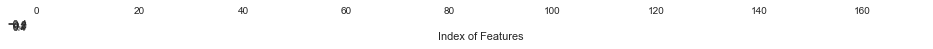

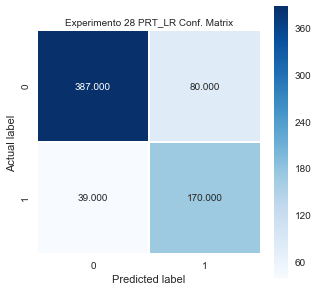

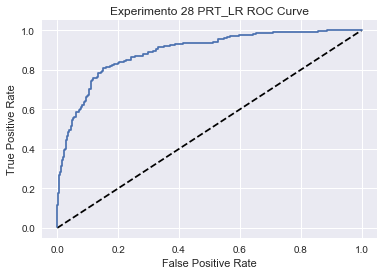

In [26]:
MODEL = 'PRT_LR'
readme['model'][MODEL] = dict()

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=12, max_features=13,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=RANDOM_STATE,
            verbose=0, warm_start=False)

select = SelectFromModel(rf, threshold='median')

select.fit(X_train, y_train)
X_train_s = select.transform(X_train)

mask = select.get_support()
plt.matshow(mask.reshape(1,-1), cmap='gray_r')
plt.xlabel('Index of Features')

X_test_s = select.transform(X_test)

log = LogisticRegression(C=0.4393970560760795, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

log.fit(X_train_s, y_train)
score = log.score(X_test_s, y_test)
print(score)

plot_confusion_matrix(log, X_test_s, y_test, log.predict(X_test_s))
roc_curve_plot(log, X_test_s, y_test)

In [27]:
log.fit(X_train_s, y_train)
# y_pred = log.predict(X_test_s)

# log.fit(X_train_s, y_train)
# predict = model.predict(X_test_s)
predict_probabilities = log.predict_proba(X_test_s)[:,1]


fpr, tpr, _ = roc_curve(y_test, predict_probabilities)

predict_mine = np.where(predict_probabilities > 0.1, 1, 0)
confusion_matrix(y_test, predict_mine)

array([[156, 311],
       [  3, 206]], dtype=int64)

In [29]:
predict_probabilities

array([5.71048922e-04, 2.99856664e-01, 7.51954213e-01, 9.60408203e-01,
       8.65305553e-01, 8.99323259e-01, 7.25697297e-01, 2.75996401e-01,
       8.61856599e-01, 9.47213468e-01, 8.03918870e-01, 1.41289307e-01,
       2.74352843e-01, 9.27561392e-01, 5.35836434e-01, 3.05756587e-01,
       7.02825400e-01, 1.26791565e-01, 4.53522041e-01, 3.23423721e-01,
       1.25959616e-01, 2.60706824e-01, 9.51409059e-01, 8.26799731e-01,
       9.11789109e-01, 8.84817840e-01, 8.81548703e-01, 8.36724001e-01,
       7.27415776e-01, 9.06593876e-01, 7.94442747e-01, 9.31782066e-01,
       3.29659972e-01, 1.82091162e-01, 3.93252137e-01, 7.84416912e-01,
       3.49348162e-01, 3.88013632e-01, 4.24010821e-01, 8.55409285e-01,
       7.15409430e-01, 7.56267592e-01, 6.76894846e-01, 2.61470525e-01,
       4.86960073e-01, 6.56353732e-01, 1.42400856e-01, 3.31869641e-02,
       5.28766300e-03, 7.58117864e-01, 9.52341881e-01, 2.11895126e-01,
       6.59346701e-03, 8.92619692e-01, 3.28723990e-01, 7.05045654e-01,
      

In [28]:
probs = log.predict_proba(X_test_s)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)

roc_auc = metrics.auc(fpr, tpr)

bla = dict()
bla['fpr'] = fpr
bla['tpr'] = tpr

bla['threshold'] = threshold
# bla
col = ['fpr', 'tpr', 'threshold']
df = pd.DataFrame.from_records(bla, columns=col)
# print(df.head())
# print(df.tail(30))

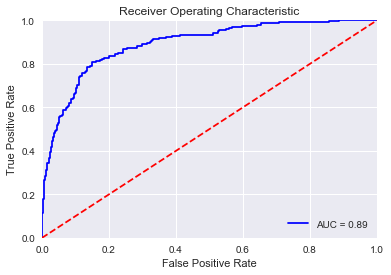

In [29]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# KNeighbors

In [30]:
import mymodels

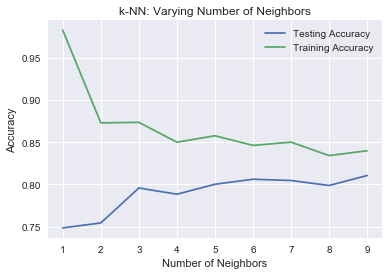

In [31]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 10)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=N_JOBS)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


# KNeighbors

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform')
           
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Best Params:  {'n_neighbors': 9}
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')
Best score is 0.8089737894269213

[[416  51]
 [ 80 129]]
             precision    recall  f1-score   support

      False       0.84      0.89      0.86       467
       True       0.72      0.62      0.66       209

avg / total       0.80      0.81      0.80       676



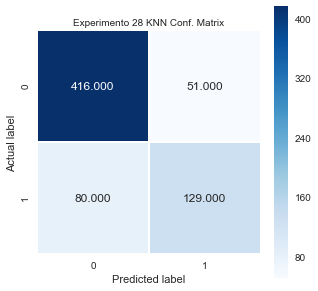

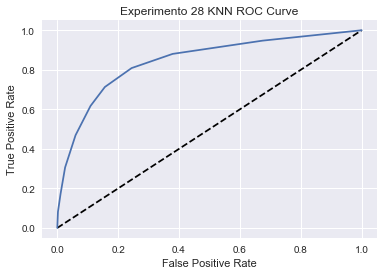

In [32]:
MODEL = 'KNN'
readme['model'][MODEL] = dict()
from sklearn.metrics import mean_squared_error
X = MinMaxScaler().fit_transform(X)

# Instantiate a k-NN classifier: knn
knn = KNeighborsClassifier()

# Param Grid
param_grid = {'n_neighbors': np.arange(1, 10)}

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# GridSearch
knn_cv = GridSearchCV(knn, param_grid, cv=kf, n_jobs=N_JOBS)
knn_cv.fit(X,y)


print("Best Params: ", knn_cv.best_params_)

print('Best Estimator: ', knn_cv.best_estimator_)



grid_results(knn_cv)

# PCA + KNN

TN -> 81:
[('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)),
('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
metric_params=None, n_jobs=1, n_neighbors=5, p=2, weights='uniform'))]

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=6)]: Done  40 out of  40 | elapsed:    6.6s finished


Best parameters set:  {'memory': None, 'steps': [('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))], 'pca': PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'clf': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), 'pca__copy': True, 'pca__iterated_power': 'auto', 'pca__n_components': 5, 'pca__random_state': None, 'pca__svd_solver': 'auto', 'pca__tol': 0.0, 'pca__whiten': False, 'clf__algorithm': 'auto', 'clf__leaf_size': 30, 'clf__metric': 'minkowski', 'clf__metric_params': None, 'clf__n_jobs': 1, 'clf__n_neighbors': 5, 'clf__p': 2, 'clf__weights': 'uniform'}


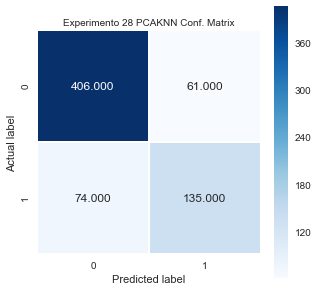

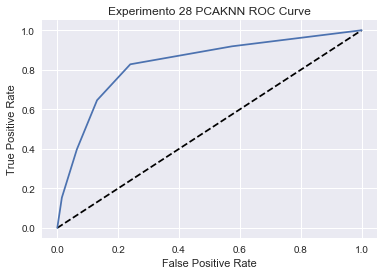

In [33]:
MODEL = 'PCAKNN'
readme['model'][MODEL] = dict()
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import LinearSVC 

pipe = Pipeline([
    ('pca', PCA()),
    ('clf', KNeighborsClassifier()),
])

parameters = {
    'pca__n_components': [2, 3, 4, 5, 6, 7, 8, 9],
    #'clf__C': [1, 10, 100],
    }

from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

gs = GridSearchCV(pipe, parameters, cv=kf, n_jobs=N_JOBS, verbose=1)
gs.fit(X, y)

best_parameters = gs.best_estimator_.get_params()
print("Best parameters set: ",best_parameters)
print('Best Estimator: ', gs.best_estimator_)
    
    
grid_results(gs)
# print("Best score: %0.3f" % gs.best_score_)


# y_pred = gs.predict(X_test) 
# # results(y_pred, y)

# plot_confusion_matrix(gs,X_test,y_test,y_pred)
# roc_curve_plot(gs, X_test, y_test)

# LogisticRegression

LogisticRegression(C=3.727593720314938, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
          
          
          
LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best score is 0.8921410090556274

## Grid

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795, 'penalty': 'l1'}
Best Estimator:  LogisticRegression(C=0.4393970560760795, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best score is 0.8329631274988893

[[423  44]
 [ 73 136]]
             precision    recall  f1-score   support

      False       0.85      0.91      0.88       467
       True       0.76      0.65      0.70       209

avg / total       0.82      0.83      0.82       676



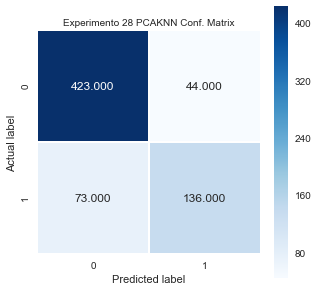

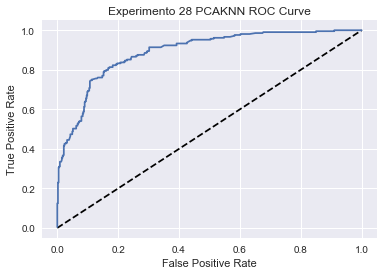

ROC AUC Score: 0.7873630933475404


In [34]:
X = MinMaxScaler().fit_transform(X)


# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
C = np.logspace(0, 4, 10)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}


# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(class_weight=None)
# logreg = LogisticRegression()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=kf, n_jobs=N_JOBS)
logreg_cv.fit(X, y)

# # Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print('Best Estimator: ', logreg_cv.best_estimator_)
# print("Best score is {}".format(logreg_cv.best_score_))
# Fit it to the data
grid_results(logreg_cv)
# # 
y_pred_prob = logreg_cv.predict_proba(X_test)[:,1]

print("ROC AUC Score:" ,roc_auc_score(y_test,y_pred_prob))

## LR Unbalanced

(1575, 173) (676, 173) (1575,) (676,)
0.8239644970414202
[[418  49]
 [ 70 139]]
             precision    recall  f1-score   support

      False       0.86      0.90      0.88       467
       True       0.74      0.67      0.70       209

avg / total       0.82      0.82      0.82       676



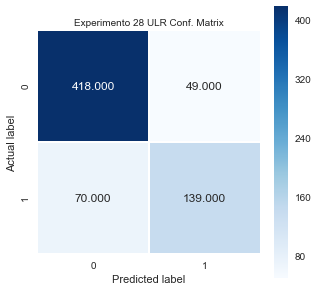

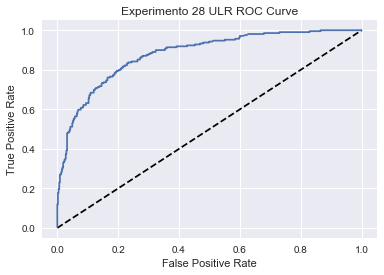

In [35]:
MODEL = 'ULR'
readme['model'][MODEL] = dict()
# Balanced Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

model = LogisticRegression(C=3.727593720314938, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(model.score(X_test, y_test))
plot_confusion_matrix(model, X_test, y_test, y_pred)

#ROC Curve
roc_curve_plot(model, X_test, y_test)

## LR Balanced

(1575, 173) (676, 173) (1575,) (676,)
0.8002958579881657
[[383  84]
 [ 51 158]]
             precision    recall  f1-score   support

      False       0.88      0.82      0.85       467
       True       0.65      0.76      0.70       209

avg / total       0.81      0.80      0.80       676



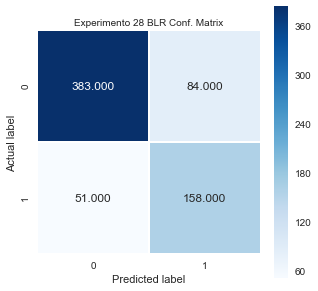

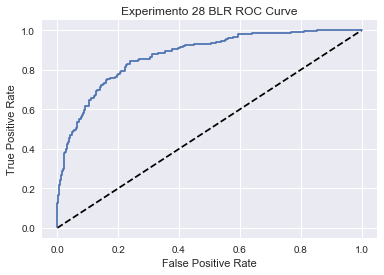

In [36]:
MODEL = 'BLR'
readme['model'][MODEL] = dict()
# Balanced Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)

model = LogisticRegression(C=3.727593720314938, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=RANDOM_STATE,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
plot_confusion_matrix(model, X_test, y_test, y_pred)

#ROC Curve
roc_curve_plot(model, X_test, y_test)

# DecisionTree

Current Bests: 

Best score is 0.8360728565082186

[[425  42]
 [ 83 126]]
             precision    recall  f1-score   support

      False       0.84      0.91      0.87       467
       True       0.75      0.60      0.67       209

avg / total       0.81      0.82      0.81       676



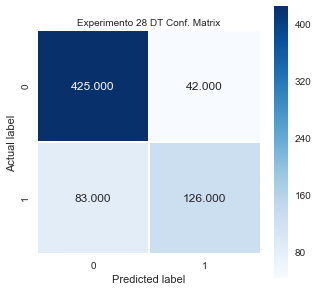

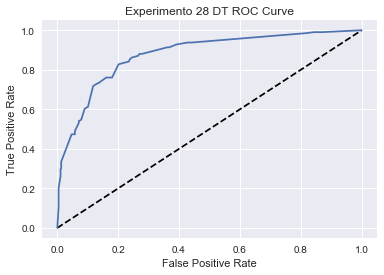

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 28, 'min_samples_leaf': 5}
Best score is 0.8360728565082186
Best estimator is DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=28, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [37]:
MODEL = 'DT'
readme['model'][MODEL] = dict()
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3,5,10,15,20, None],
              "max_features": randint(1, 30),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

param_dist = {
    "max_depth": range(1,20),
    "max_features":range(1,30),
    "min_samples_leaf": range(1,10),
    "criterion": ["gini", "entropy"]
}

# Instantiate a Decision Tree classifier: tree
# tree = DecisionTreeClassifier(class_weight='balanced')
tree = DecisionTreeClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
# tree_cv = RandomizedSearchCV(tree, param_dist, cv=kf)
tree_cv = GridSearchCV(tree, param_dist, cv=kf, n_jobs=N_JOBS)


# Fit it to the data
tree_cv.fit(X,y)
grid_results(tree_cv)

# # Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
print("Best estimator is {}".format(tree_cv.best_estimator_))

,importance,labels
21,0.394049,San Andres Del Valle
3,0.182786,is_direccion
4,0.163896,is_fnac
15,0.054857,nro_cot_depto
12,0.045096,mean_cot_esta


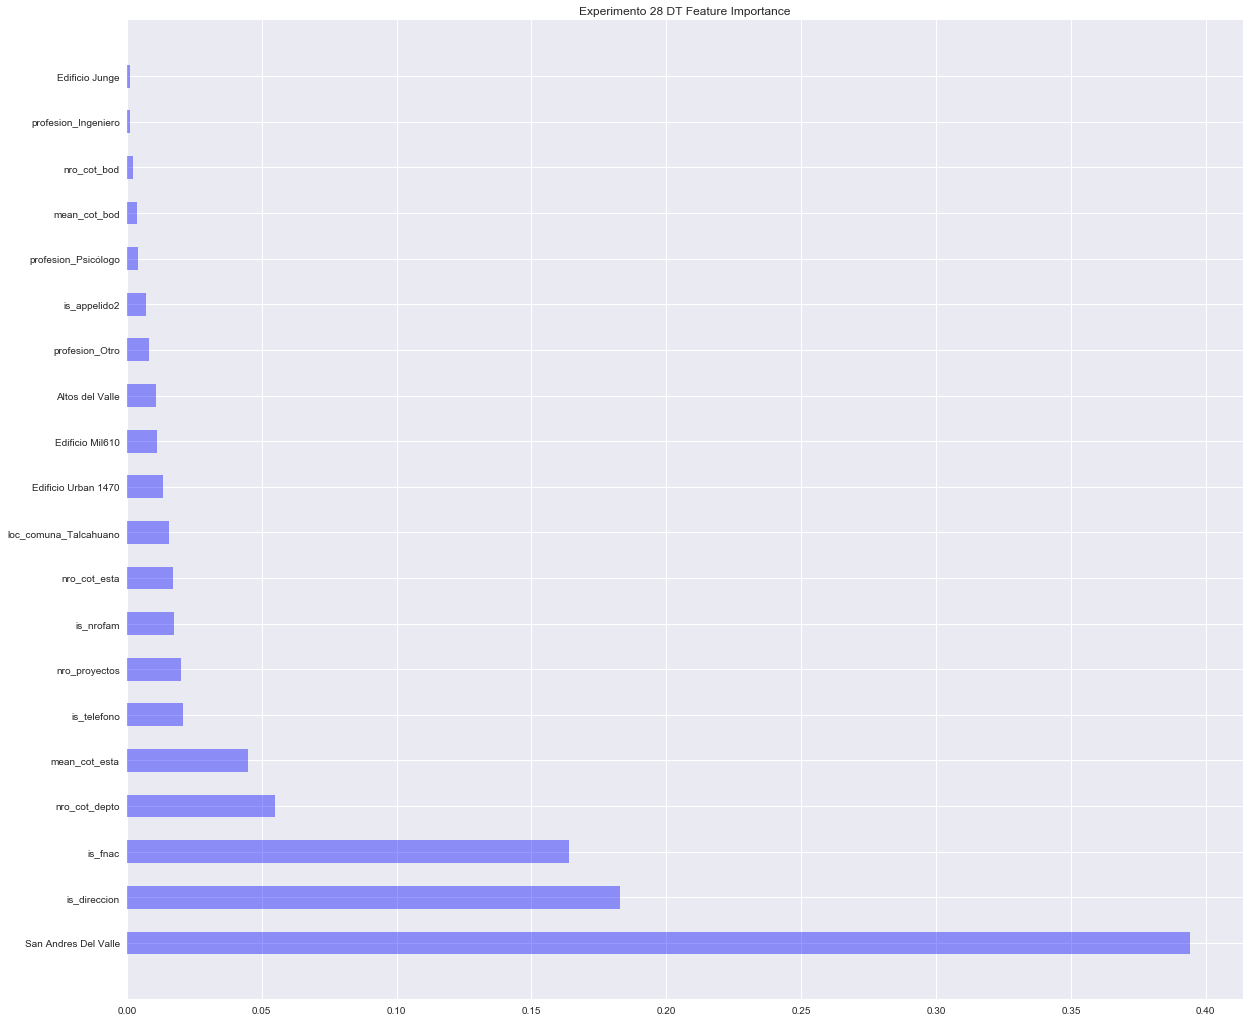

In [38]:
plot_importance_graph(tree_cv)

# RandomForest

Current Bests:

## GRID Unbalanced

Best estimator is RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=13, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Tuned Decision Tree Parameters: {'n_estimators': 90, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 13, 'criterion': 'gini', 'bootstrap': True}
Best score is 0.8485117725455353
Best score is 0.8485117725455353

[[439  28]
 [ 89 120]]
             precision    recall  f1-score   support

      False       0.83      0.94      0.88       467
       True       0.81      0.57      0.67       209

avg / total       0.83      0.83      0.82       676



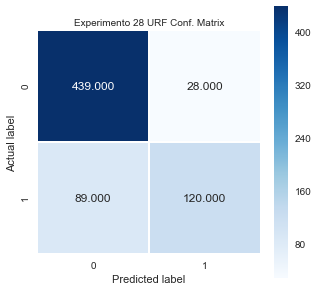

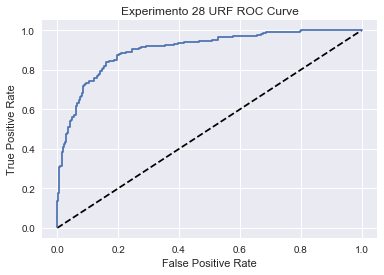

,importance,labels
3,0.212565,is_direccion
15,0.166090,nro_cot_depto
21,0.135220,San Andres Del Valle
4,0.105766,is_fnac
7,0.040920,is_nrofam


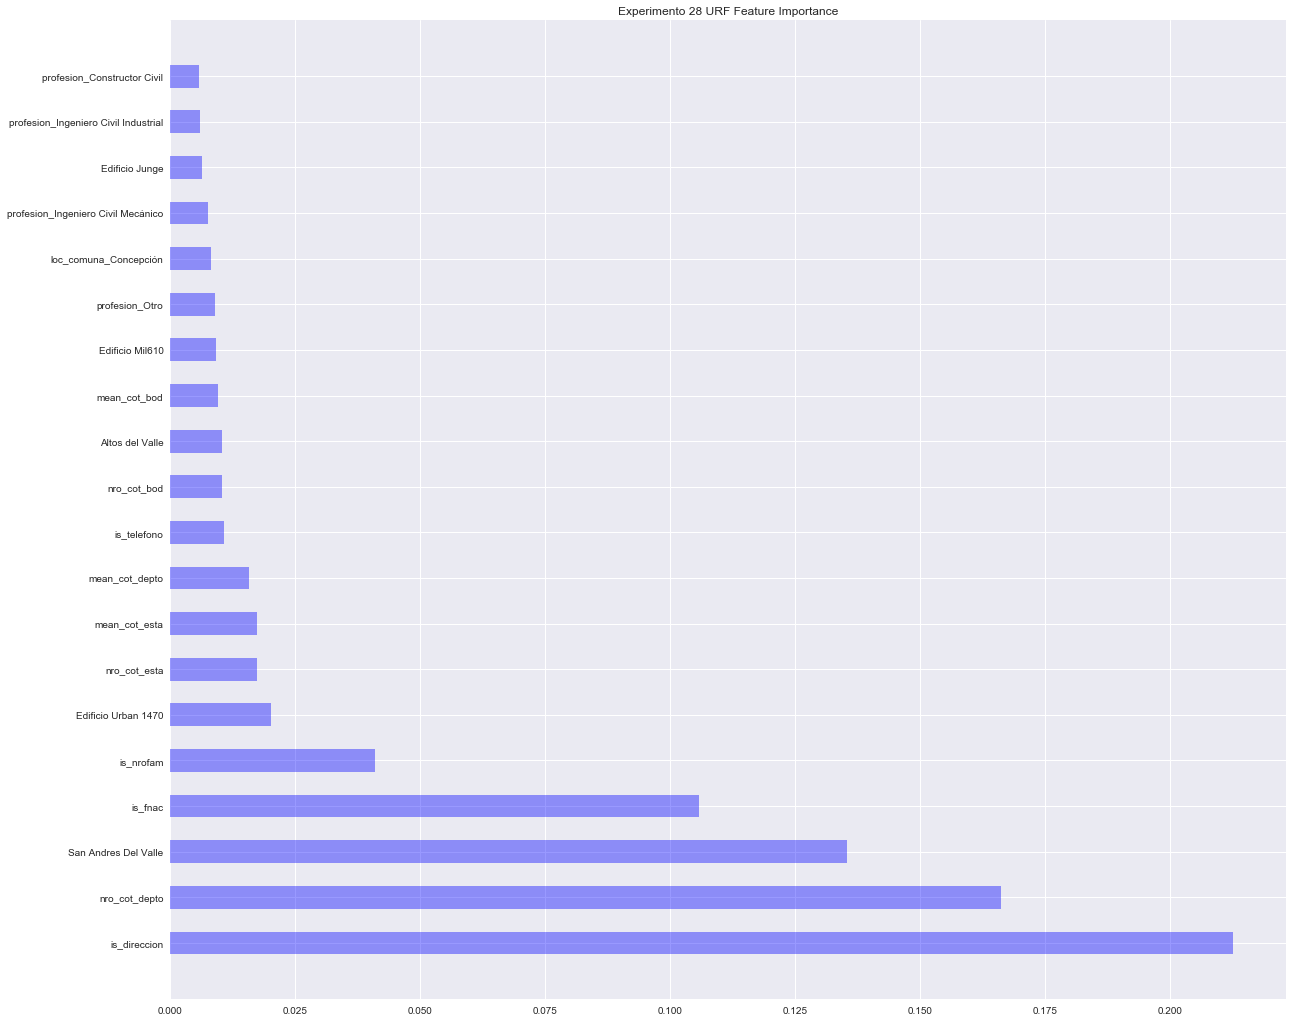

In [39]:
# Setup the parameters and distributions to sample from: param_dist
MODEL = 'URF'
readme['model'][MODEL] = dict()
param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}
param_grid = {"max_depth": list(range(1,30)),
              'max_features': ['auto', 'sqrt', 'log2'],
#               "max_features":range(1,40),
              "min_samples_split": list(range(2,30)),
              "min_samples_leaf": list(range(1,20)),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators":list(range(20,100,10)),
#               "class_weight":[None,'balanced' ],
}

# Instantiate a Decision Tree classifier: tree
rf = RandomForestClassifier()

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Instantiate the RandomizedSearchCV object: tree_cv
rf_cv = RandomizedSearchCV(rf, param_grid, cv=kf, n_jobs=N_JOBS, n_iter=300)
# rf_cv = GridSearchCV(rf, param_grid, cv=kf, n_jobs=N_JOBS)

# Fit it to the data
rf_cv.fit(X,y)

# Predict
# y_pred = rf_cv.predict(X_test)

# Print the tuned parameters and score
print("Best estimator is {}".format(rf_cv.best_estimator_))
print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

grid_results(rf_cv)
# # Confusion Matrix
# plot_confusion_matrix(rf_cv, X_test, y_test, y_pred)

# # ROC Curve
# roc_curve_plot(rf_cv, X_test, y_test)

# Feature Importance
plot_importance_graph(rf_cv)

## GRID Balanced

Best Params:  {'min_samples_leaf': 4, 'max_features': 22, 'max_depth': 10, 'criterion': 'gini'}
Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=22,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy:  0.8742603550295858
[[383  84]
 [ 51 158]]
             precision    recall  f1-score   support

      False       0.88      0.82      0.85       467
       True       0.65      0.76      0.70       209

avg / total       0.81      0.80      0.80       676



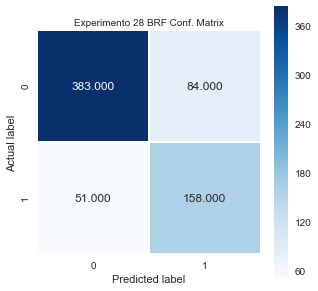

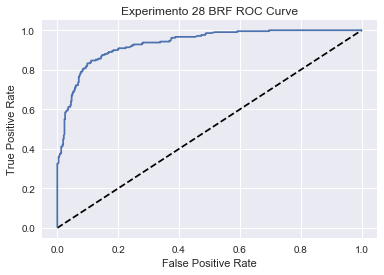

,importance,labels
3,0.259649,is_direccion
15,0.182848,nro_cot_depto
4,0.170181,is_fnac
21,0.157115,San Andres Del Valle
7,0.044631,is_nrofam


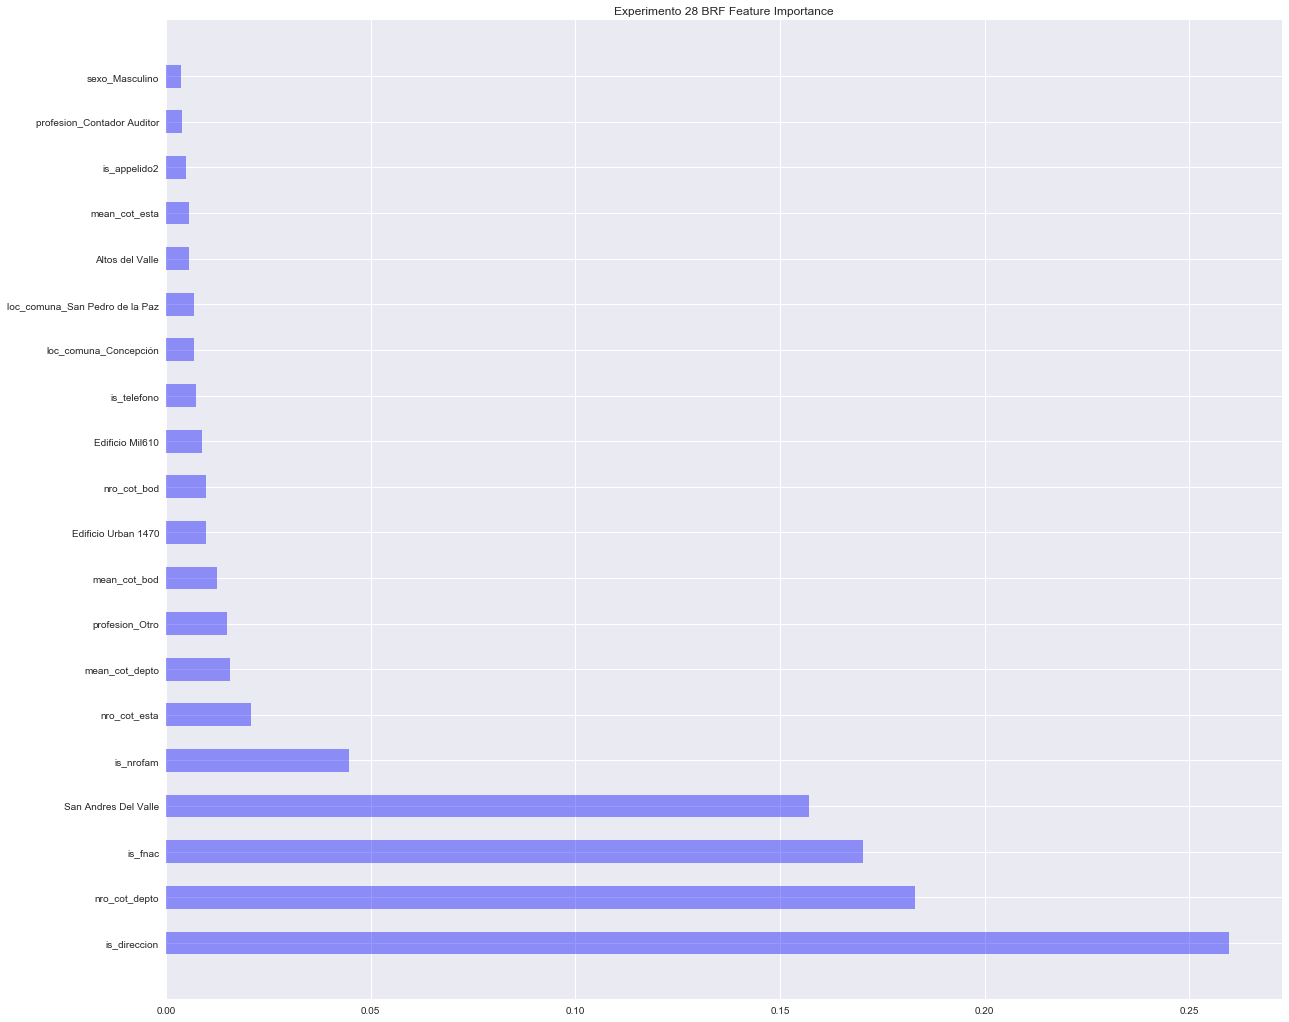

In [40]:
MODEL = 'BRF'
readme['model'][MODEL] = dict()
param_grid = {
    "max_depth": randint(1,30),
    "max_features":randint(1,40),
    "min_samples_leaf": randint(1,20),
    "criterion": ["gini", "entropy"],
    "min_samples_split": randint(2,20),
    "n_estimators":[20,30,40,50,60,70,80,90,100],
    "bootstrap": [True, False],
}

randomForest = RandomForestClassifier(class_weight='balanced')

# Stratified
from sklearn.model_selection import GridSearchCV, StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# RandomSearch
randomForest_cv = RandomizedSearchCV(randomForest, param_dist, cv=kf, n_jobs=N_JOBS)
# Grid Search
# randomForest_cv = GridSearchCV(randomForest, param_grid, cv=kf, n_jobs=-1)

# Train
randomForest_cv.fit(X, y)

print("Best Params: ", randomForest_cv.best_params_)
print('Best Estimator: ', randomForest_cv.best_estimator_)

model = randomForest_cv.best_estimator_
# Make predictions
predictions = model.predict(X_test)

probs = model.predict_proba(X_test)
# display(predictions)

score = model.score(X_test, y_test)
print("Accuracy: ", score)

plot_confusion_matrix(model, X_test, y_test, y_pred)

roc_curve_plot(model, X_test, y_test)

plot_importance_graph(randomForest_cv)

### 3.5.6 SVM

C:\Users\joaquin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\joaquin\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


{'C': 10, 'gamma': 0.1}
Tuned Logistic Regression Parameters: {'C': 10, 'gamma': 0.1}
Best score is 0.8138605064415815
Best score is 0.8138605064415815

[[385  82]
 [ 53 156]]
             precision    recall  f1-score   support

      False       0.88      0.82      0.85       467
       True       0.66      0.75      0.70       209

avg / total       0.81      0.80      0.80       676



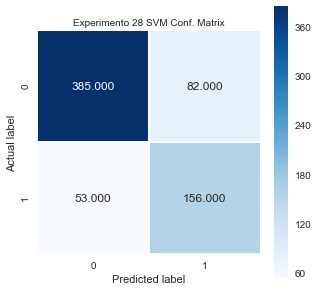

In [41]:
MODEL = 'SVM'
readme['model'][MODEL] = dict()

from sklearn import svm, grid_search

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

grid_search = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

grid_search.fit(X, y)

print(grid_search.best_params_)


# y_pred = grid_search.predict(X)
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(grid_search.best_params_)) 
print("Best score is {}".format(grid_search.best_score_))

grid_results(grid_search, plot_roc_curve=False)

# plot_confusion_matrix(grid_search,X , y, y_pred)

In [42]:
>>> import numpy as np
>>> from sklearn import metrics
>>> y = np.array([1, 1, 2, 2])
>>> scores = np.array([0.1, 0.4, 0.35, 0.8])
>>> fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
>>> print(fpr)
>>> print(tpr)
>>> print(thresholds)

[0.  0.5 0.5 1. ]
[0.5 0.5 1.  1. ]
[0.8  0.4  0.35 0.1 ]


In [43]:
import numpy as np
import matplotlib.pyplot as plt
def pdf(x, std, mean):
    const = 1.0 / np.sqrt(2*np.pi*(std**2))
    pdf_normal_dist = const*np.exp(-((x-mean)**2)/(2.0*(std**2)))
    return pdf_normal_dist
x = np.linspace(0, 1, num=100)
good_pdf = pdf(x,0.1,0.4)
bad_pdf = pdf(x,0.1,0.6)

In [44]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

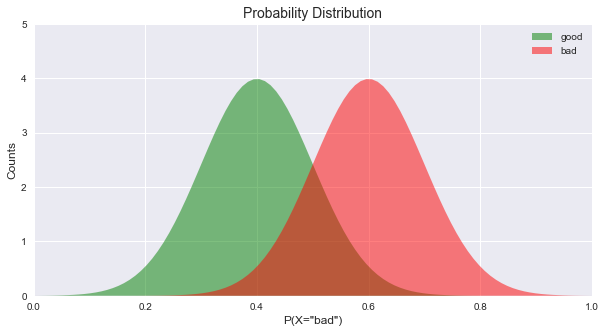

In [45]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax)

In [46]:
def plot_roc(good_pdf, bad_pdf, ax):
    #Total
    total_bad = np.sum(bad_pdf)
    total_good = np.sum(good_pdf)
    #Cumulative sum
    cum_TP = 0
    cum_FP = 0
    #TPR and FPR list initialization
    TPR_list=[]
    FPR_list=[]
    #Iteratre through all values of x
    for i in range(len(x)):
        #We are only interested in non-zero values of bad
        if bad_pdf[i]>0:
            cum_TP+=bad_pdf[len(x)-1-i]
            cum_FP+=good_pdf[len(x)-1-i]
        FPR=cum_FP/total_good
        TPR=cum_TP/total_bad
        TPR_list.append(TPR)
        FPR_list.append(FPR)
    #Calculating AUC, taking the 100 timesteps into account
    auc=np.sum(TPR_list)/100
    #Plotting final ROC curve
    ax.plot(FPR_list, TPR_list)
    ax.plot(x,x, "--")
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title("ROC Curve", fontsize=14)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_xlabel('FPR', fontsize=12)
    ax.grid()
    ax.legend(["AUC=%.3f"%auc])

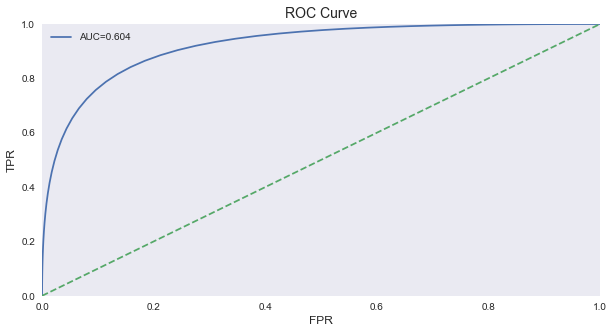

In [47]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
plot_roc(good_pdf, bad_pdf, ax)

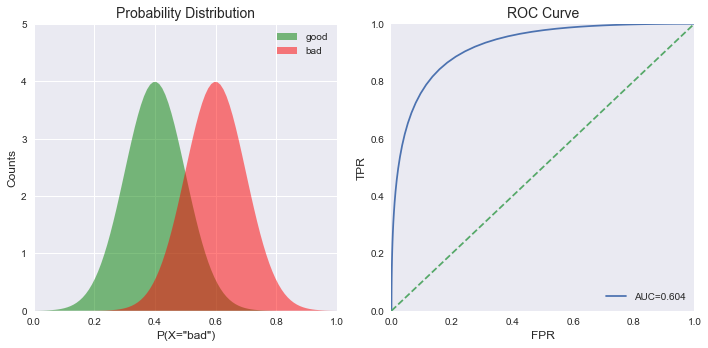

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_pdf(good_pdf, bad_pdf, ax[0])
plot_roc(good_pdf, bad_pdf, ax[1])
plt.tight_layout()

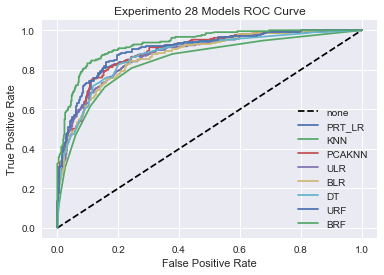

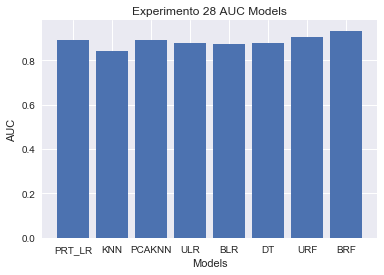

In [49]:
plot_all_roc_curves()
plot_all_auc_values()